# Problem Set 4, PAM Pulses #
<p>Pulse Amplitude Modulation with manchester ('man'), and &quot;manchester sine&quot; ('msin')
  pulses added.</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook
fsz = (7, 4)
fsz1 = (fsz[0], 1.4*fsz[1])
fsz2 = (fsz[0], fsz[1]/2.0)

In [3]:
def asc2bin(txt, bits):
    """
    ASCII character sequence to binary string conversion.
    >>>>> dn = asc2bin(txt, bits) <<<<<
    where  dn       binary output string
           txt      text input (ASCII)
           bits<0   MSB first conversion
           bits>=0  LSB first conversion
           |bits|   number of bits per character
    """
    txt_10 = list(ord(chr) for chr in txt)
    if (bits < 0):
        pow2 = list(2**(i+1) for i in range(bits,0))
    else:
        pow2 = list((2**-i) for i in range(bits))
    B = np.array(np.outer(txt_10, pow2), int)
    B = np.mod(B, 2)
    dn = np.reshape(B, -1)
    return dn

In [4]:
def bin2asc(dn, bits):
    """
    Binary string to ASCII character string conversion.
    >>>>> txt = bin2asc(dn, bits) <<<<<
    where  txt      output string (ASCII)
           dn       binary string
           bits<0   MSB first conversion
           bits>=0  LSB first conversion
           |bits|   number of bits per character
    """
    Lb = int(np.floor(len(dn)/abs(bits)))  # length in multiples of 'bits'
    dn = dn[:Lb*abs(bits)]
    B = np.reshape(dn, (-1, abs(bits)))
    if (bits < 0):
        pow2 = list(2**(i-1) for i in range(abs(bits),0,-1))
    else:
        pow2 = list(2**i for i in range(bits))
    txt_10 = np.inner(B, pow2)
    return ''.join(chr(i) for i in txt_10) 

In [5]:
def pam_pt(FB, Fs, ptype, pparms=[]):
    """
    Generate PAM pulse p(t)
    >>>>> ttp, pt = pam_pt(FB, Fs, ptype, pparms) <<<<<
    where  ttp:   time axis for p(t)
           pt:    PAM pulse p(t)
           FB:    Baud rate  (Fs/FB=sps)
           Fs:    sampling rate of p(t)
           ptype: pulse type from list
                  ('man', 'msin', rcf', 'rect', 'sinc', 'tri')
           pparms not used for 'man', 'msin', 'rect', 'tri'
           pparms = [k, alfa]  for 'rcf'
           pparms = [k, beta]  for 'sinc'
           k:     "tail" truncation parameter for 'sinc'
                  (truncates p(t) to -k*TB <= t < k*TB)
           beta:  Kaiser window parameter for 'sinc'
           alfa: Rolloff parameter for 'rcf', 0<=alfa<=1
    """
    ptyp = ptype.lower()
    if (ptyp=='rect' or ptyp=='man' or ptyp=='msin'):
        kR = 0.5; kL = -kR
    elif ptyp=='tri':
        kR = 1.0; kL = -kR
    elif (ptyp=='rcf' or ptyp=='sinc'):
        kR = pparms[0]; kL = -kR
    else:
        kR = 0.5; kL = -kR
    tpL, tpR = kL/float(FB), kR/float(FB)
    ixpL, ixpR = int(np.ceil(tpL*Fs)), int(np.ceil(tpR*Fs))
    ttp = np.arange(ixpL, ixpR)/float(Fs)  # time axis for p(t)
    pt = np.zeros(ttp.size)
    if ptyp=='man':
        pt = -np.ones(ttp.size)
        ixp = np.where(ttp>=0)
        pt[ixp] = 1
    elif ptyp=='msin':
        pt = np.sin(2*np.pi*FB*ttp)
    elif ptyp=='rcf':
        pt = np.sinc(FB*ttp)
        if pparms[1] != 0:
            p2t = np.pi/4.0*np.ones(ttp.size)
            ix = np.where(np.power(2*pparms[1]*FB*ttp, 2.0) != 1)[0]
            p2t[ix] = np.cos(np.pi*pparms[1]*FB*ttp[ix])
            p2t[ix] = p2t[ix]/(1-np.power(2*pparms[1]*FB*ttp[ix],2.0))
            pt = pt*p2t
    elif ptyp=='rect':    
        ixp = np.where(np.logical_and(ttp>=tpL,ttp<tpR))[0]
        pt[ixp] = 1    # rectangular pulse p(t)
    elif ptyp=='sinc':
        pt = np.sinc(FB*ttp)
        if len(pparms) > 1:        # Apply Kaiser window 
            pt = pt*np.kaiser(len(pt),pparms[1])
    elif ptyp=='tri':
        pt = 1 + FB*ttp
        ixp = np.where(ttp>=0)[0]
        pt[ixp] = 1 - FB*ttp[ixp]
    else:
        ix0 = np.argmin(np.abs(ttp))
        pt[ix0] = 1
    return ttp, pt

In [6]:
def pam13(an, FB, Fs, ptype, pparms=[]):
    """
    Pulse amplitude modulation: a_n -> s(t), -TB/2<=t<(N-1/2)*TB,
    V1.3 for 'man', 'msin', 'rcf', 'rect', 'sinc', and 'tri' pulse types.
    >>>>> tt, st = pam13(an, FB, Fs, ptype, pparms) <<<<<
    where  tt:    time axis for PAM signal s(t) (starting at -TB/2)
           st:    PAM signal s(t)
           an:    N-symbol DT input sequence a_n
           FB:    baud rate of a_n, TB=1/FB
           Fs:    sampling rate of s(t)
           ptype: pulse type from list
                  ('man', 'msin', 'rcf', 'rect', 'sinc', 'tri')
           pparms not used for 'man', 'msin', 'rect', 'tri'
           pparms = [k, alpha] for 'rcf'
           pparms = [k, beta]  for 'sinc'
           k:     "tail" truncation parameter for 'rcf', 'sinc'
                  (truncates p(t) to -k*TB <= t < k*TB)
           alpha: Rolloff parameter for 'rcf', 0<=alpha<=1       
           beta:  Kaiser window parameter for 'sinc'
    """
    N = len(an)
    ixL = round(-0.5*Fs/float(FB))    # Left index for time axis
    tlen = N/float(FB)   # duration of PAM signal in sec
    tt = np.arange(round(Fs*tlen))/float(Fs)
    tt = tt + ixL/float(Fs)   # shift time axis left by TB/2
    ixa = np.array(np.round(Fs/float(FB)*(0.5+np.arange(N))),np.int64)
    ast = np.zeros(tt.size)
    ast[ixa] = Fs*an   # as(t) is CT version of an
    ttp, pt = pam_pt(FB, Fs, ptype, pparms)
    # Convolution  as(t)*p(t)
    st = np.convolve(ast, pt)/float(Fs)  # s(t) = a_s(t)*p(t)
    ixttp0 = np.argmin(np.abs(ttp))  # index for t=0 on ttp 
    st = st[ixttp0:]  # trim after convolution
    st = st[:tt.size]  # PAM signal s(t)
    return tt, st

In [7]:
# Parameters
Fs = 8000    # sampling rate
FB = 100     # Baud rate FB = 1/TB
bits = 8     # bits per char, LSB first conversion
polar = 1    # polar or unipolar
Nsym = 100   # number of symbols
ptype1, pparms1 = 'man', []
ptype2, pparms2 = 'msin', []
dn = np.random.randint(2, size=Nsym)

In [8]:
# Create single pulse p(t) for display
ptlen = 1     # p(t) duration
Npt = round(FB*ptlen)
pn = np.zeros(Npt)
pn[round(Npt/2.0)] = 1
ttpt, p1t = pam13(pn, FB, Fs, ptype1, pparms1)
ttpt, p2t = pam13(pn, FB, Fs, ptype2, pparms2)
ttpt = ttpt-round(Npt/2.0)/float(FB)
P1f = np.fft.fft(np.fft.fftshift(p1t))/float(Fs)   # FT approximation
P2f = np.fft.fft(np.fft.fftshift(p2t))/float(Fs)
NPf = P1f.size
DPf = Fs/float(NPf)
ffPf = DPf*np.arange(NPf)-Fs/2.0
P1f = np.fft.fftshift(P1f)
absP1f = np.abs(P1f)
ix = np.where(absP1f<1e-200)
absP1f[ix] = 1e-200
P2f = np.fft.fftshift(P2f)
absP2f = np.abs(P2f)
ix = np.where(absP2f<1e-200)
absP2f[ix] = 1e-200

<IPython.core.display.Javascript object>


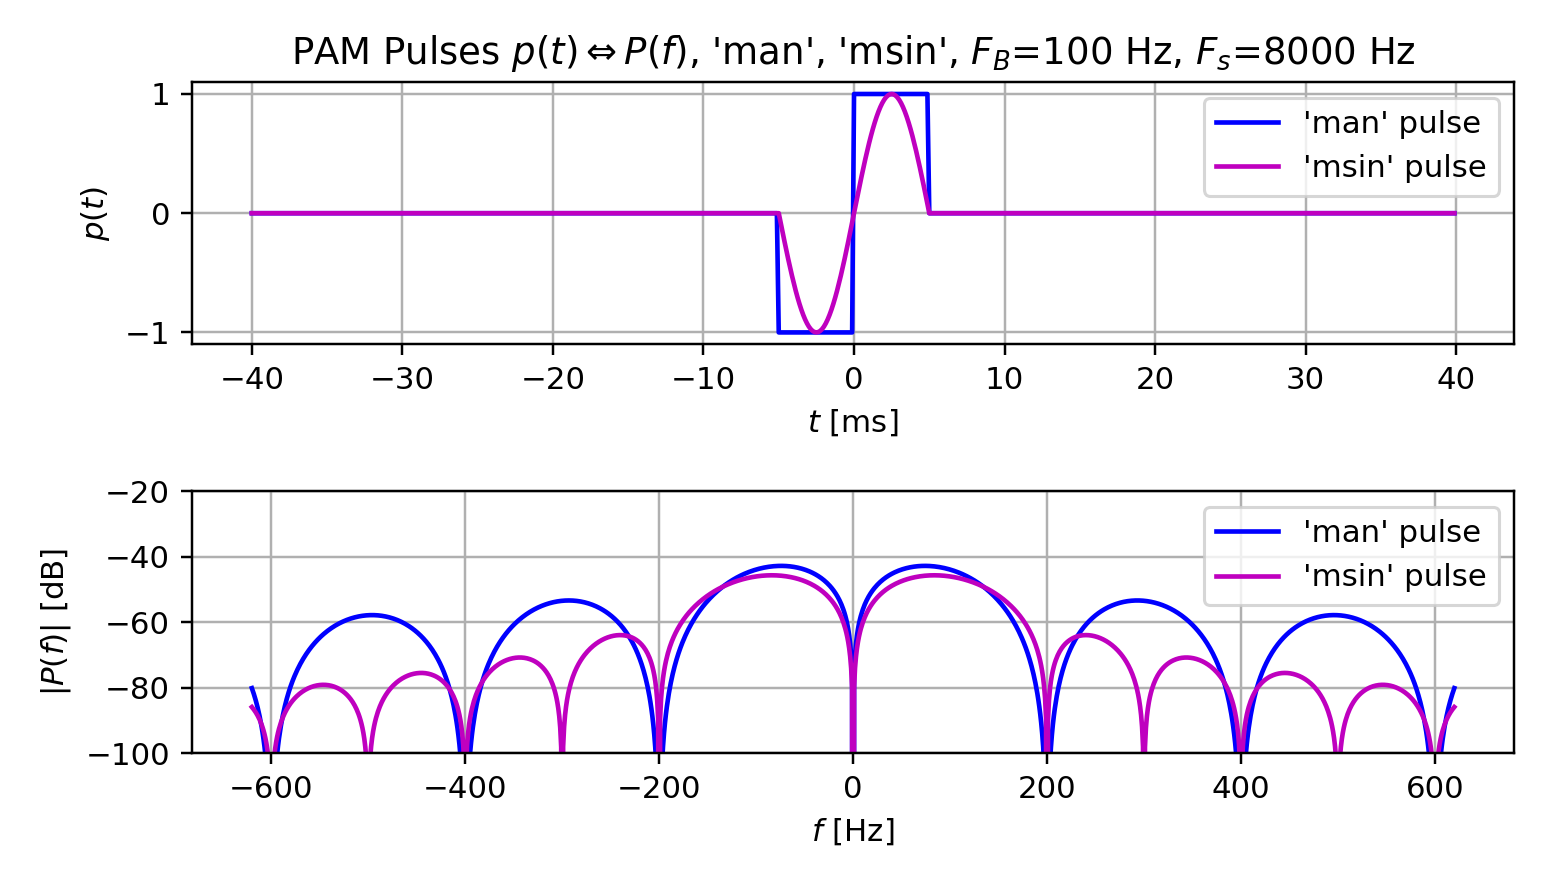

In [9]:
ttpt2 = 4/float(FB); ttpt1 = -ttpt2
ffPf2 = 6.2*FB; ffPf1 = -ffPf2
ixdttpt = np.where(np.logical_and(ttpt>=ttpt1, ttpt<=ttpt2))
ixdffPf = np.where(np.logical_and(ffPf>=ffPf1, ffPf<=ffPf2))
plt.figure(3, figsize=fsz)
plt.subplot(211)
plt.plot(1e3*ttpt[ixdttpt], p1t[ixdttpt], '-b', label="'man' pulse")
plt.plot(1e3*ttpt[ixdttpt], p2t[ixdttpt], '-m', label="'msin' pulse")
strt3 = "PAM Pulses $p(t)\Leftrightarrow P(f)$, '{}', '{}'".format(ptype1, ptype2)
strt3 = strt3 + ', $F_B$={} Hz'.format(FB)
strt3 = strt3 + ', $F_s$={} Hz'.format(Fs)
plt.ylabel('$p(t)$')
plt.xlabel('$t$ [ms]')
plt.title(strt3)
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(ffPf[ixdffPf], 20*np.log10(absP1f[ixdffPf]), '-b', label="'man' pulse")
plt.plot(ffPf[ixdffPf], 20*np.log10(absP2f[ixdffPf]), '-m', label="'msin' pulse")
plt.ylabel('$|P(f)|$ [dB]')
plt.xlabel('$f$ [Hz]')
plt.ylim([-100, -20])
plt.legend()
plt.grid()
plt.tight_layout()

In [10]:
# Generate PAM signal s(t)
if polar:
    an = 2*dn-1
else:
    an = dn
tt, s1t = pam13(an, FB, Fs, ptype1, pparms1) 
tt, s2t = pam13(an, FB, Fs, ptype2, pparms2) 
S1f = np.fft.fft(s1t)/float(Fs)
S2f = np.fft.fft(s2t)/float(Fs)
NSf = S1f.size
DSf = Fs/float(NSf)
ff = DSf*np.arange(NSf)-Fs/2.0
S1f = np.fft.fftshift(S1f)
absS1f = np.abs(S1f)
ix = np.where(absS1f<1e-200)
absS1f[ix] = 1e-200
S2f = np.fft.fftshift(S2f)
absS2f = np.abs(S2f)
ix = np.where(absS2f<1e-200)
absS2f[ix] = 1e-200

In [11]:
# s(t) sampling times
dlys = 0.25   # sampling delay as fraction of TB
NSs = FB/float(Fs)*np.floor(s1t.size)
ixss = np.array(np.round(Fs/float(FB)*(0.5+np.arange(NSs)+dlys)),np.int64)
       # sampling times (n+dlys)*TB
ix = np.where(np.logical_and(ixss>=0, ixss<s1t.size))[0]
ixss = ixss[ix]     # trim ixss values to indexes in s(t)
s1n = s1t[ixss]
s2n = s2t[ixss]

<IPython.core.display.Javascript object>


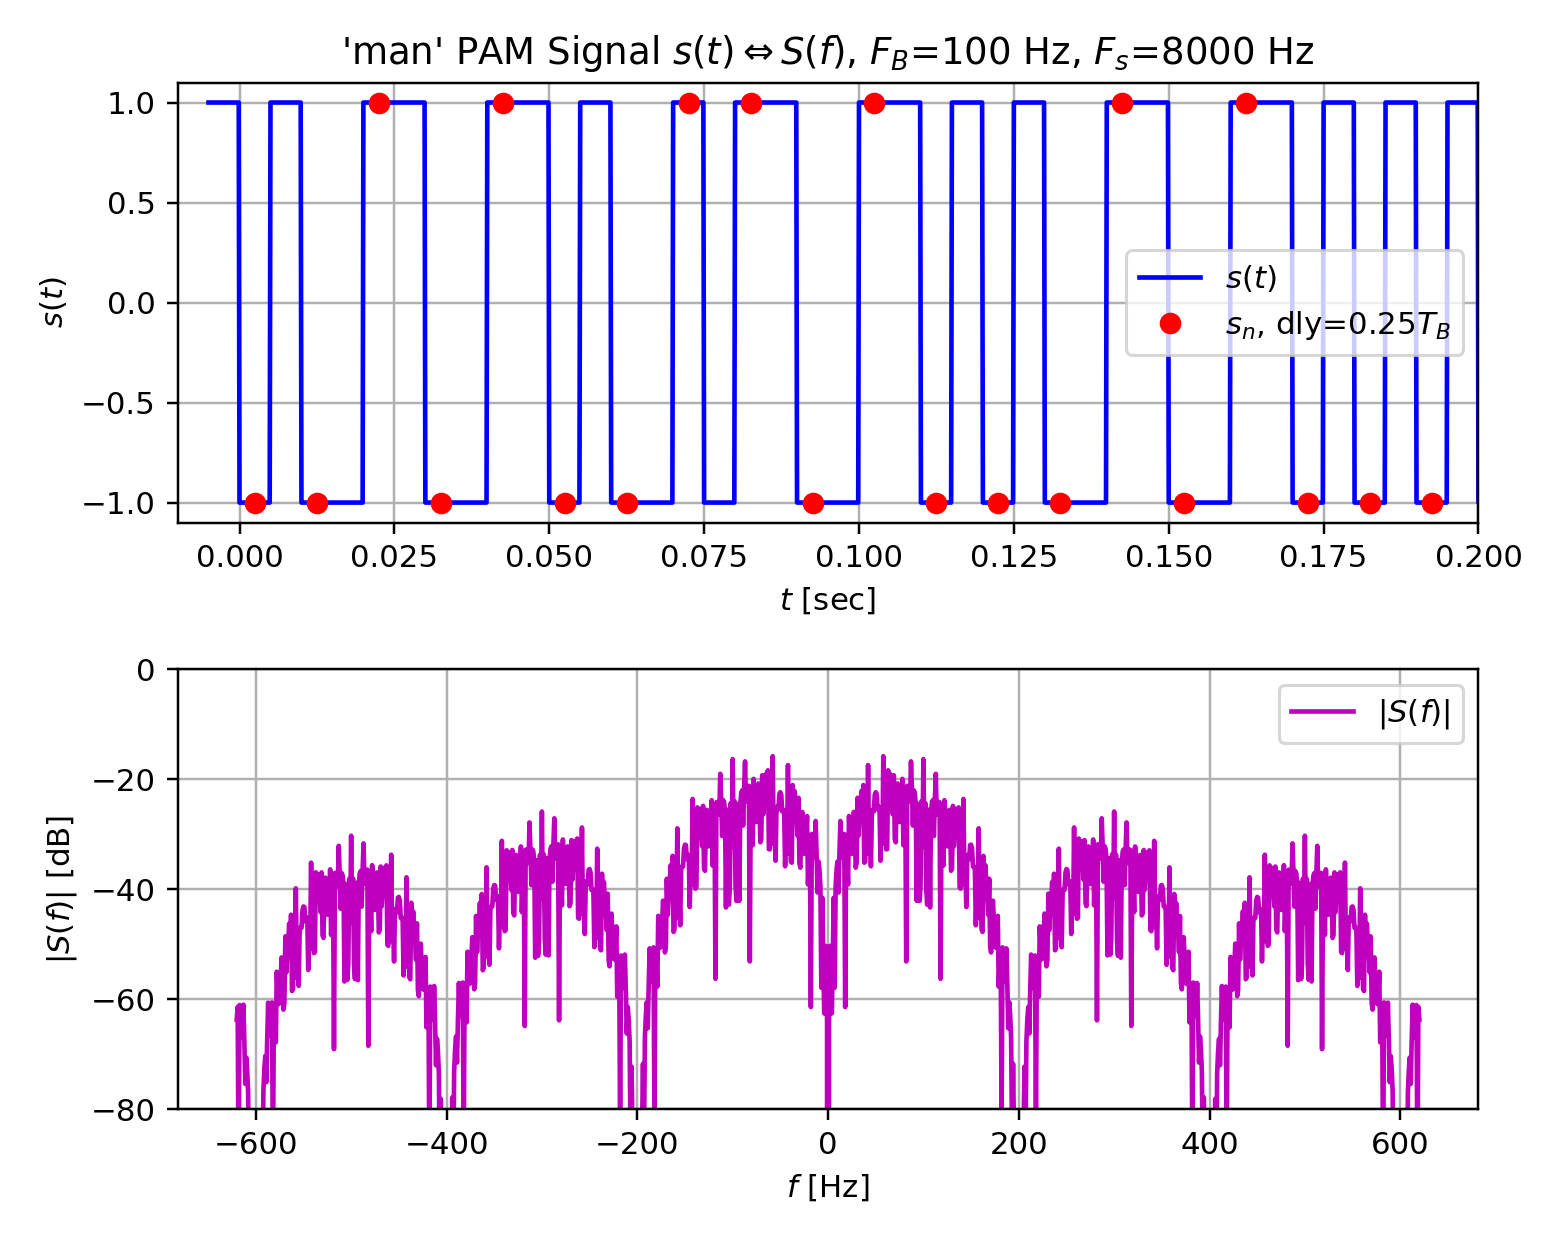

In [12]:
ff2 = 6.2*FB; ff1 = -ff2
ixdff = np.where(np.logical_and(ff>=ff1, ff<=ff2))
plt.figure(7, figsize=fsz1)
plt.subplot(211)
plt.plot(tt, s1t, '-b', label='$s(t)$')
plt.plot(tt[ixss], s1t[ixss], 'or', label='$s_n$, dly={}$T_B$'.format(dlys))
plt.xlim([-0.01, 0.2])
strt7 = "'{}' PAM Signal $s(t) \Leftrightarrow S(f)$".format(ptype1)
strt7 = strt7 + ', $F_B$={} Hz'.format(FB)
strt7 = strt7 + ', $F_s$={} Hz'.format(Fs)
plt.title(strt7)
plt.ylabel('$s(t)$')
plt.xlabel('$t$ [sec]')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(ff[ixdff], 20*np.log10(absS1f[ixdff]), '-m', label='$|S(f)|$')
plt.ylim([-80, 0])
plt.ylabel('$|S(f)|$ [dB]')
plt.xlabel('$f$ [Hz]')
plt.legend()
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


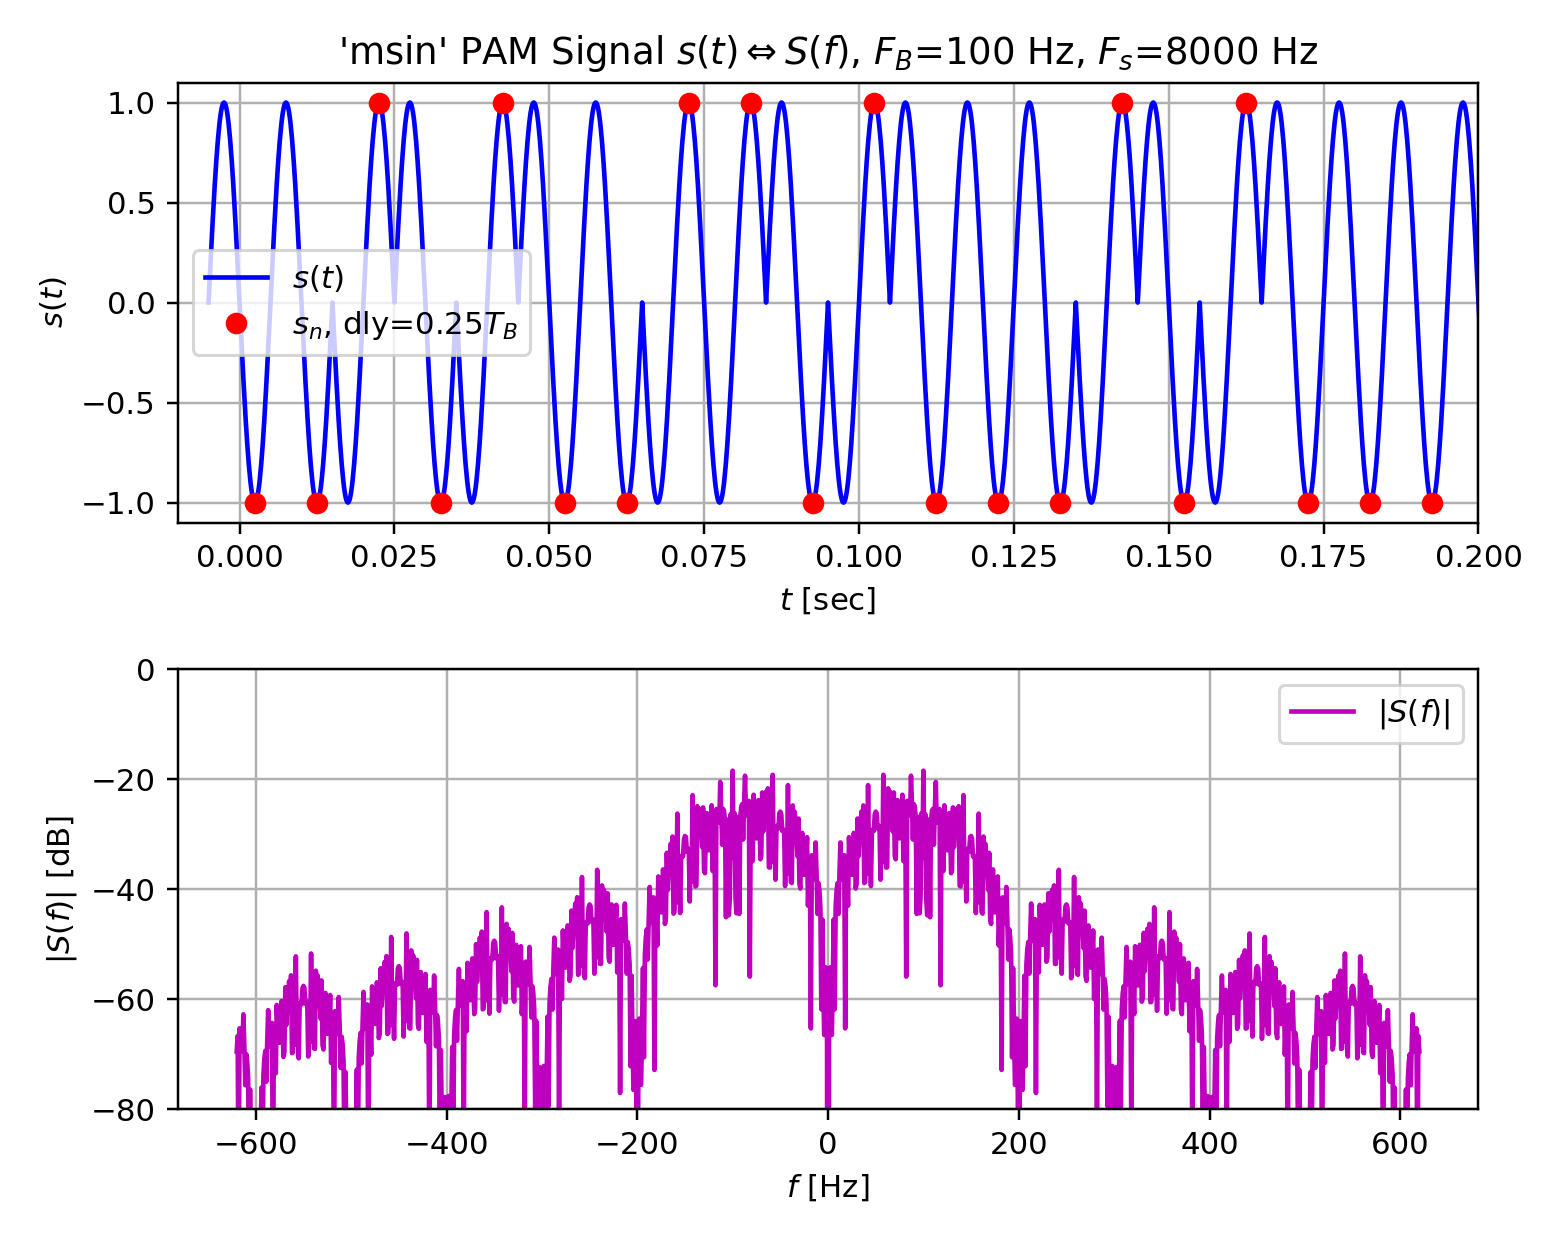

In [13]:
ff2 = 6.2*FB; ff1 = -ff2
ixdff = np.where(np.logical_and(ff>=ff1, ff<=ff2))
plt.figure(11, figsize=fsz1)
plt.subplot(211)
plt.plot(tt, s2t, '-b', label='$s(t)$')
plt.plot(tt[ixss], s2t[ixss], 'or', label='$s_n$, dly={}$T_B$'.format(dlys))
plt.xlim([-0.01, 0.2])
strt11 = "'{}' PAM Signal $s(t) \Leftrightarrow S(f)$".format(ptype2)
strt11 = strt11 + ', $F_B$={} Hz'.format(FB)
strt11 = strt11 + ', $F_s$={} Hz'.format(Fs)
plt.title(strt11)
plt.ylabel('$s(t)$')
plt.xlabel('$t$ [sec]')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(ff[ixdff], 20*np.log10(absS2f[ixdff]), '-m', label='$|S(f)|$')
plt.ylim([-80, 0])
plt.ylabel('$|S(f)|$ [dB]')
plt.xlabel('$f$ [Hz]')
plt.legend()
plt.grid()
plt.tight_layout()

<p>The main features of both the 'man' and the 'msin' pulse are a zero dc component
  and the first zero crossing of the spectrum at $2\,F_B$. The spectrum of the
  'msin' pulse decreases faster with increasing $f$ than the spectrum of the 'man'
  pulse.
</p>    